<a href="https://colab.research.google.com/github/HYPEREON008/learning-journey/blob/main/software/mazePathPlanningCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Computer Vision Q5 (both Astar and BFS)

---



In [ ]:
# imports
import cv2
import numpy as np
import heapq
from google.colab.patches import cv2_imshow # For displaying images in Colab


In [ ]:
# Load and process image
img = cv2.imread("maze_ibot_dc.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY_INV)
#cv2.THRESH_BINARY_INV: If a pixel's intensity is greater than thresh, it's set to 0;
#otherwise, it's set to maxval(1 in this case)

# wall = 1, path = 0 (higher intensity so inverted to zero)

In [ ]:
# Detect START and GOAL positions using color
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# HSV makes color-based segmentation robust by separating “what color it is”(Hue)
# from “how bright” or “how pure/intensity” it is (Value, Saturation respectively)

# Green mask for start
lower_green, upper_green = np.array([40,40,40]), np.array([80,255,255])
mask_green = cv2.inRange(hsv, lower_green, upper_green)
green_coords = np.column_stack(np.where(mask_green>0))
#np.where() returns 2 numpy arrays one for y one for x respectively
#(for points that satisfy the conditipn)
#column_stack stacks this 2 arrays as side by side columns (2D array made)
start = np.mean(green_coords, axis=0)
#avg of the columns (0 axis ~ vertical)
start = start.astype(int)[::-1] # (x, y) and both converted to int
start = tuple(start)

# Blue mask for goal
lower_blue, upper_blue = np.array([100,40,40]), np.array([140,255,255])
mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
blue_coords = np.column_stack(np.where(mask_blue>0))
goal = tuple((np.mean(blue_coords, axis=0)).astype(int)[::-1])




In [ ]:
# Helpful Morphology

# binary_display = (binary * 255).astype(np.uint8)

# cv2.imshow("Binary Maze", binary_display)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

print("Start:", start)
print("Goal:", goal)

#add a little boundary to the start and end to account for
#dark boundary around the START and GOAL
kernel = np.ones((3,3), np.uint8)
#unsigned 8-bit integer for display(0-255)
dilated_blue = cv2.dilate(mask_blue, kernel, iterations=3)
dilated_green = cv2.dilate(mask_green, kernel, iterations=3)

# Clear start marker area
binary[dilated_green > 0] = 0

# Clear goal marker area
binary[dilated_blue > 0] = 0

# binary_display = (binary * 255).astype(np.uint8)

# cv2.imshow("Binary Maze", binary_display)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Start: (np.int64(609), np.int64(50))
Goal: (np.int64(194), np.int64(405))


In [ ]:
# BFS Pathfinding
def bfs(start, goal, binary):
    h, w = binary.shape
    visited = np.zeros((h, w), dtype=bool)
    parent = dict()

    QUEUE = [start]  # list as QUEUE (FIFO)
    visited[start[1], start[0]] = True  # binary[y,x]
    nodes_explored = 0

    while QUEUE:
        CURRENT = QUEUE.pop(0)
        nodes_explored += 1
        x, y = CURRENT

        if CURRENT == goal:
            # reconstruct path
            path = []
            while CURRENT != start:
                path.append(CURRENT)
                CURRENT = parent[CURRENT]
            path.append(start)
            path.reverse()
            return path, nodes_explored

        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            newx, newy = x+dx, y+dy
            # for neighbour(newx,newy) in neighbours
            if 0 <= newx < w and 0 <= newy < h:
                if not visited[newy, newx] and binary[newy, newx] == 0:
                    visited[newy, newx] = True
                    parent[(newx, newy)] = CURRENT
                    QUEUE.append((newx, newy))

    return None, nodes_explored

In [ ]:
# A star pathfinding

def astar(start, goal, binary):
  h, w = binary.shape
  g_cost = np.full((h, w), np.inf)
  parent = dict()

  g_cost[start[1], start[0]] = 0
  def h_cost(a, b):  # Manhattan distance; our heuristic
      return abs(a[0] - b[0]) + abs(a[1] - b[1])

  PQ = []  # priority queue
  heapq.heappush(PQ, (h_cost(start, goal), start))  # (f_cost=(0+h_cost), node)
  nodes_explored = 0

  while PQ:
      f_cost, CURRENT = heapq.heappop(PQ)
      nodes_explored += 1
      x,y = CURRENT

      if CURRENT == goal:
          #reconstruct path
          path = []
          while CURRENT != start:
              path.append(CURRENT)
              CURRENT = parent[CURRENT]
          path.append(start)
          path.reverse()
          return path, nodes_explored

      for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
          newx, newy = x+dx, y+dy
          if 0 <= newx < w and 0 <= newy < h:
            # for neighbour(newx,newy) in neighbours
              if binary[newy, newx] == 0:
                  new_cost = g_cost[y, x] + 1
                  if new_cost < g_cost[newy, newx]:
                      g_cost[newy, newx] = new_cost
                      parent[(newx, newy)] = CURRENT

                      heapq.heappush(PQ, (new_cost + h_cost((newx, newy), goal), (newx, newy)))

  return None, nodes_explored

In [ ]:
#path, nodes_explored = bfs(start, goal, binary)
path, nodes_explored = astar(start, goal, binary)


Path length: 4171
Nodes explored: 292676


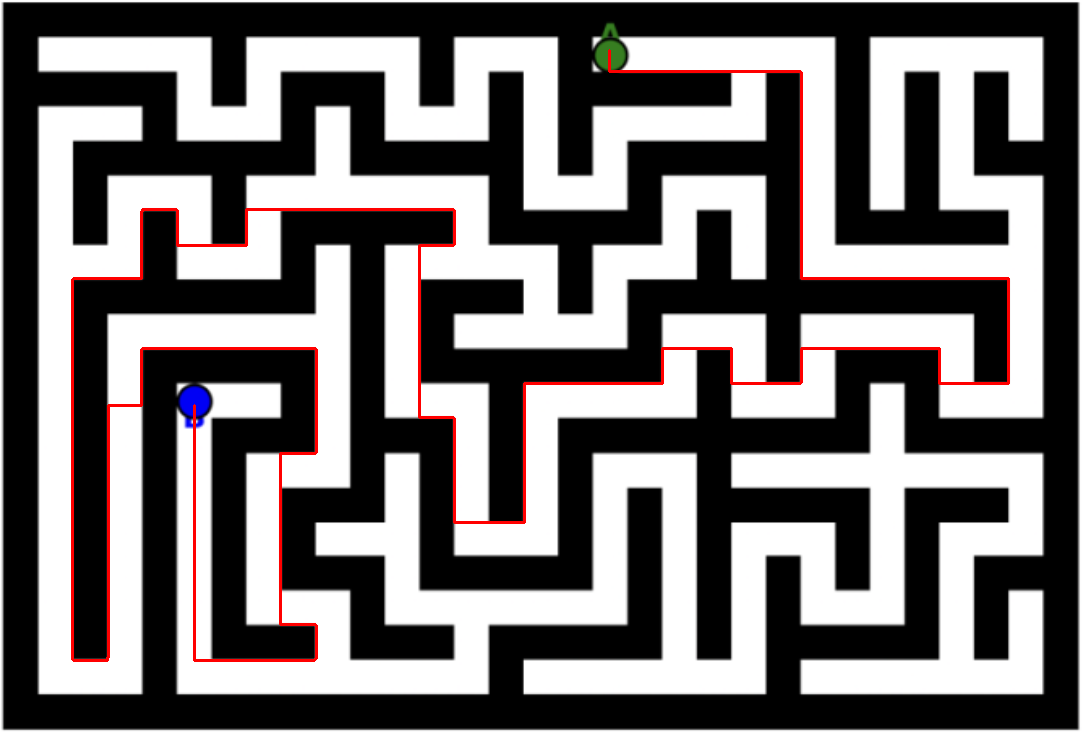

In [ ]:
# Visualization
if path:
    for i in range(len(path)-1):
        cv2.line(img, path[i], path[i+1], (0,0,255), 2)  # red path, 2 thickness
    print("Path length:", len(path))
    print("Nodes explored:", nodes_explored)

    cv2_imshow(img) #for google colab

# # for normal running in editor
    # cv2.imshow("Path", img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
else:
    print("No path found")